In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
#
#
# There are two derivatives functions, one for noise and one for 0 noise.  
# 
#

def raw_spectra(df, noise_std):
    '''
    Applies and smooths noise to averaged spectra.
    '''
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])

    noise = np.random.normal(0, noise_std, [10000,1000])
    X_noise = X + noise
    X_noise.columns = list
    for index, row in X_noise.iterrows():
        X_noise.loc[index] = savgol_filter(row, 101, 3)

    for index, row in X_noise.iterrows():
        X_noise.loc[index] = savgol_filter(row, 51, 2)  

    if noise_std == 0:
        features = X
    else:
        features=X_noise

    return features

def derivatives_zero_noise(mu_df, dx=0.80808080808):
    '''
    Calculates and returns the first and second derivative of the spectra - only used when there is zero noise.
    '''

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)-1])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)-2])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)-1):
            dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
    
    dmu1_2 = np.concatenate([dmu1, dmu2], axis=1)       

    return dmu1, dmu2, dmu1_2

def derivatives_noise(features, dx=0.80808080808):
    '''
    raw_spectra applies noise and smooths the spectra then returns the smoothed spectra 'features', this functions uses 
    the smoothed spectra to calculate the first derivative, smooth the first derivative, then calculate the second derivative.
    It returns the smoothed first derivative and the calculated second derivative.
    '''
    
    dmu1 = np.zeros([len(features), len(features.columns)-1])
    dmu2 = np.zeros([len(features), len(features.columns)-2])
    
    if len(features.columns) == 1000:
        dx =0.1*dx

    for i in range(len(features)):
        for j in range(len(features.columns)-1):
            dmu1[i, j] = (features.iloc[i, j+1] - features.iloc[i, j]) / dx
    
    dmu1 = pd.DataFrame(dmu1)
    for index, row in dmu1.iterrows():
        dmu1.loc[index, :] = savgol_filter(row, 51,2)
    dmu1 = np.asarray(dmu1)

    for i_ in range(len(features)):
        for j_ in range(len(features.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
            
    dmu1_2 = np.concatenate([dmu1, dmu2], axis=1)

    return dmu1, dmu2, dmu1_2    

#
# Run train layer to train multiple epochs, find the best epoch will then train using the best epoch 
# analyse_layer will then return loss data, append_data_to_list then stores the loss data 
# and finally plot_data will plot parity plots for each feature. run_layer calls all these functions 
#

def train_layer(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    loss = []
    for i in range(100):
        if i == 0:
            pass
        else:
            nn = MLPRegressor(hidden_layer_sizes=(i), activation='identity', solver='lbfgs', max_iter=2000, 
                              random_state=28)
            nn = nn.fit(X_train, y_train)
            loss.append(nn.loss_)

    lossdf = pd.DataFrame(loss)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(lossdf)
    return lossdf

def find_best_epoch(lossdf, X_train, y_train):
    '''
    find_best_epoch is a function to return the epoch with the lowest loss, and the loss value
    '''
    
    min_loss = lossdf.idxmin()[0]+1
    print(min_loss)
    best_nn = MLPRegressor(hidden_layer_sizes=(min_loss), activation='identity', solver='lbfgs', max_iter=2000, 
                           random_state=28)
    best_nn = best_nn.fit(X_train, y_train)
    loss = best_nn.loss_
    print(loss)
    
    return min_loss, loss, best_nn

def analyse_layer(X_train, X_test, y_train, y_test, best_nn):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = best_nn.predict(X_train)
    y_test_pred = best_nn.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, train_mse_Cu, train_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                         score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_i_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_i_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_i_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_i_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_i_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_i_list.append(score_Te)

def plot_layer(y_test, y_test_pred):
    '''
    plot_layer is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
              score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    lossdf = train_layer(X_train, y_train)
    min_loss, loss, best_nn  = find_best_epoch(lossdf, X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, best_nn)
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, 
                         rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    plot_layer(y_test, y_test_pred)

#
#  MLP_per_noise functions will itterate through each noise value and return the results
#  There is a unique function for spectrum, first derivative, second derivative, and
#  both derivatives combined
#

def MLP_per_noise_spectra(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                          score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise
    '''
    for entry in Noise_STD:
        print('noise_std: ', entry)
        X = raw_spectra(df, entry)
        y = df[['CN', 'Num Cu', 'Num Te']]
        X_train, X_test, y_train, y_test = train_test_split(df, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                  score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

    print(rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    return rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list

def MLP_per_noise_1(df, Noise_STD, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, 
                    rmse_Te_i_list_1, score_Te_i_list_1):
    for entry in Noise_STD:
        if entry == 0:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df1, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                      score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
        else: 
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df1, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                      score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
        

    print(rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, 
                    score_Te_i_list_1)
    return rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1
    
def MLP_per_noise_2(df, Noise_STD, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, 
                    rmse_Te_i_list_2, score_Te_i_list_2):
    for entry in Noise_STD:
        if entry == 0:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df2, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                  score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
        else:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df2, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                      score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
    
    
    print(rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, 
            score_Te_i_list_2)
    return rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2
    
def MLP_per_noise_1_2(df, Noise_STD, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2):
    for entry in Noise_STD:
        if entry == 0:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df3, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
        else:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df3, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
    

    print(rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, 
            score_Te_i_list_1_2)
    return rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2
    

# 
# The following functions deal with iterating through each noise multiple times and averaging them   
# compile_score_lists functions itterate and store lists of loss data
# average_scores functions take the average of each noise level 
# There is a unique set of average_scores and compile_score_lists for the spectrum, the first derivative, 
# the decond derivative, and both derivatives combined
#

def average_scores_spectra(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_spectra(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_spectra = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_spectra
    
def compile_score_lists_spectra(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_spectra(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1
    
def compile_score_lists_1(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_1(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_2
    
def compile_score_lists_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_2(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1_2
    
def compile_score_lists_1_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_1_2(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

    

Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [12]:
df = pd.read_csv('mu_cn1000_energies.csv')

# Train with Spectra Only:

Create dataframes for plotting noise vs R2 an RMSE

In [10]:
Noise_STD = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
iterations = 20

In [13]:
#These are the parameters used to test the code:

Noise_STD = [0, 0.005]
iterations = 2

noise_std:  0
           0
0   0.007481
1   0.000034
2   0.000026
3   0.000032
4   0.000056
5   0.000013
6   0.000026
7   0.000026
8   0.000020
9   0.000033
10  0.000043
11  0.000026
12  0.000011
13  0.000028
14  0.000042
15  0.000027
16  0.000019
17  0.000031
18  0.000029
19  0.000013
20  0.000028
21  0.000014
22  0.000049
23  0.000049
24  0.000017
25  0.000031
26  0.000040
27  0.000024
28  0.000012
29  0.000013
30  0.000010
31  0.000043
32  0.000029
33  0.000037
34  0.000044
35  0.000017
36  0.000011
37  0.000039
38  0.000015
39  0.000011
40  0.000014
41  0.000039
42  0.000035
43  0.000011
44  0.000023
45  0.000016
46  0.000039
47  0.000030
48  0.000026
49  0.000030
50  0.000027
51  0.000015
52  0.000014
53  0.000026
54  0.000012
55  0.000033
56  0.000027
57  0.000052
58  0.000043
59  0.000020
60  0.000012
61  0.000014
62  0.000031
63  0.000016
64  0.000030
65  0.000034
66  0.000032
67  0.000029
68  0.000021
69  0.000039
70  0.000035
71  0.000033
72  0.000043
73  0.000030
74  0.00002

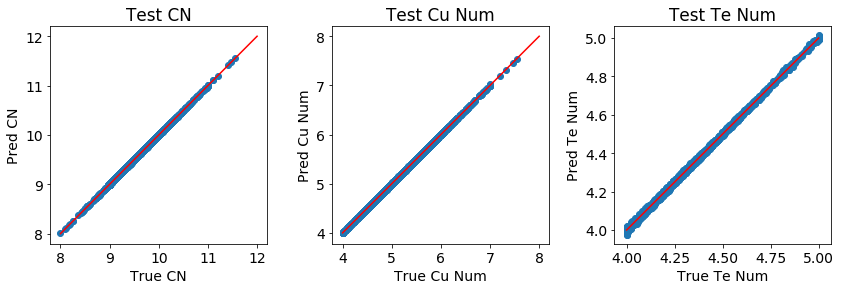

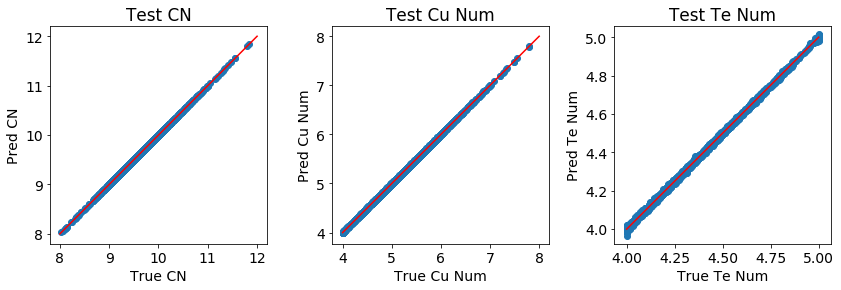

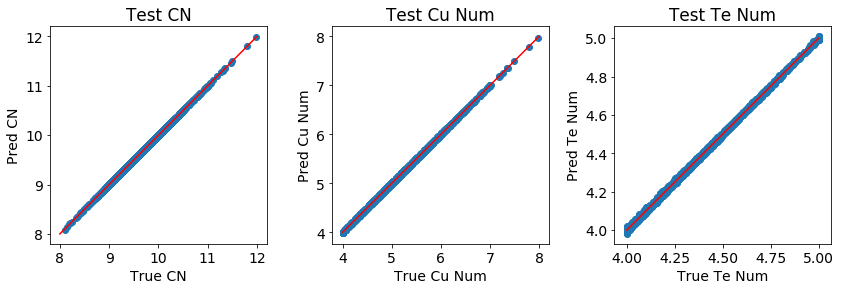

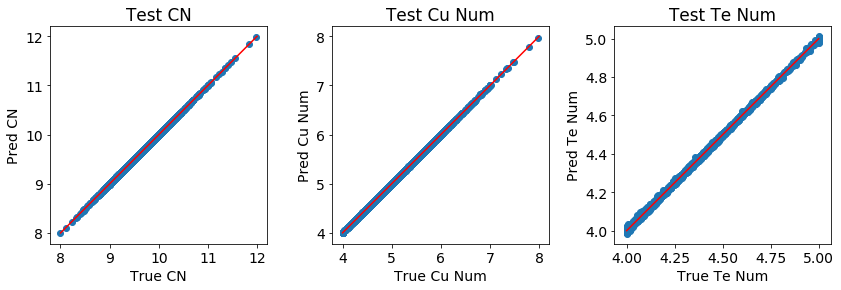

In [14]:
results_df_spectra = average_scores_spectra(iterations, df, Noise_STD)

# Train with first derivative:

           0
0   0.007503
1   0.000291
2   0.000265
3   0.000334
4   0.000291
5   0.000317
6   0.000314
7   0.000317
8   0.000295
9   0.000303
10  0.000294
11  0.000289
12  0.000337
13  0.000386
14  0.000325
15  0.000365
16  0.000344
17  0.000326
18  0.000366
19  0.000361
20  0.000305
21  0.000376
22  0.000355
23  0.000306
24  0.000307
25  0.000290
26  0.000349
27  0.000334
28  0.000361
29  0.000292
30  0.000418
31  0.000524
32  0.000322
33  0.000308
34  0.000294
35  0.000449
36  0.000354
37  0.000366
38  0.000357
39  0.000353
40  0.000343
41  0.000408
42  0.000316
43  0.000371
44  0.000392
45  0.000319
46  0.000481
47  0.000287
48  0.000324
49  0.000401
50  0.000535
51  0.000400
52  0.000337
53  0.000425
54  0.000379
55  0.000361
56  0.000312
57  0.000368
58  0.000458
59  0.000389
60  0.000540
61  0.000392
62  0.000327
63  0.000350
64  0.000499
65  0.000556
66  0.000384
67  0.000436
68  0.000385
69  0.000592
70  0.000400
71  0.000430
72  0.000333
73  0.000352
74  0.000337
75  0.000380

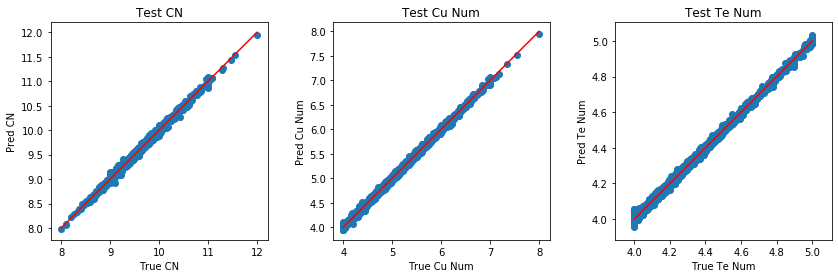

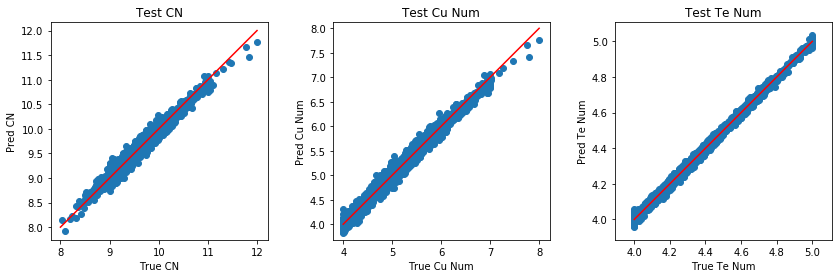

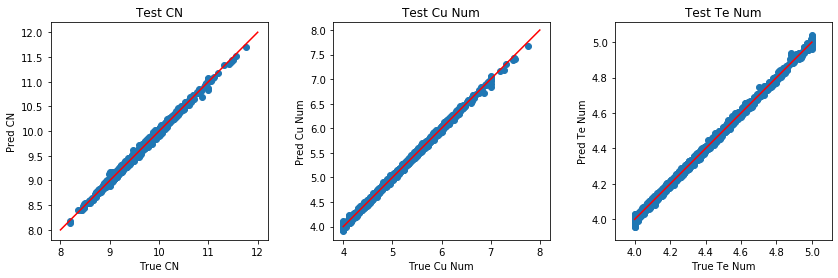

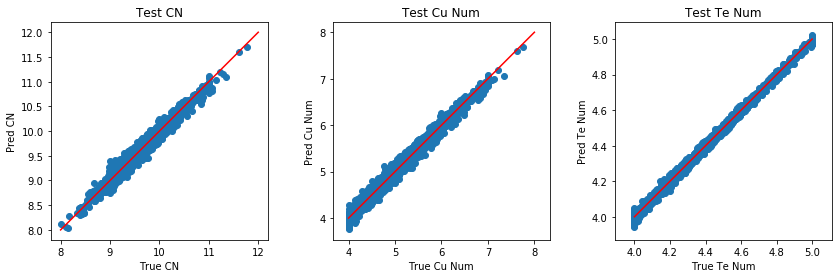

In [5]:
results_df_1 = average_scores_1(iterations, df, Noise_STD)

# Train with second derivative:

           0
0   0.007721
1   0.000368
2   0.000381
3   0.000410
4   0.000452
5   0.000443
6   0.000504
7   0.000459
8   0.000467
9   0.000409
10  0.000457
11  0.000469
12  0.000430
13  0.000363
14  0.000502
15  0.000331
16  0.000459
17  0.000454
18  0.000464
19  0.000472
20  0.000484
21  0.000507
22  0.000325
23  0.000483
24  0.000476
25  0.000487
26  0.000539
27  0.000475
28  0.000426
29  0.000520
30  0.000436
31  0.000548
32  0.000489
33  0.000502
34  0.000475
35  0.000483
36  0.000539
37  0.000565
38  0.000482
39  0.000483
40  0.000527
41  0.000471
42  0.000555
43  0.000493
44  0.000521
45  0.000547
46  0.000528
47  0.000502
48  0.000463
49  0.000537
50  0.000535
51  0.000493
52  0.000571
53  0.000589
54  0.000535
55  0.000612
56  0.000661
57  0.000512
58  0.000458
59  0.000598
60  0.000547
61  0.000475
62  0.000495
63  0.000492
64  0.000540
65  0.000526
66  0.000622
67  0.000563
68  0.000514
69  0.000564
70  0.000509
71  0.000530
72  0.000818
73  0.000487
74  0.000534
75  0.000568

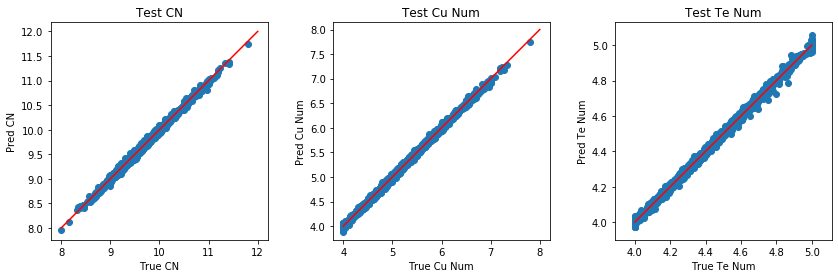

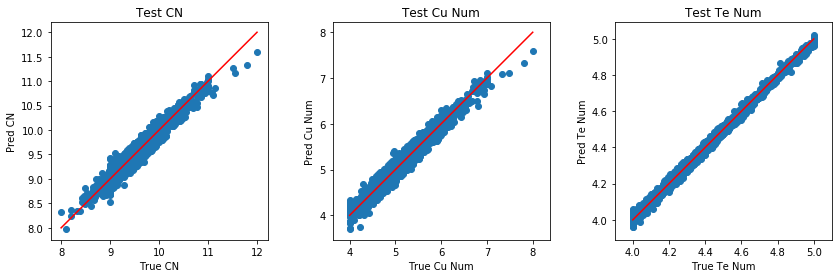

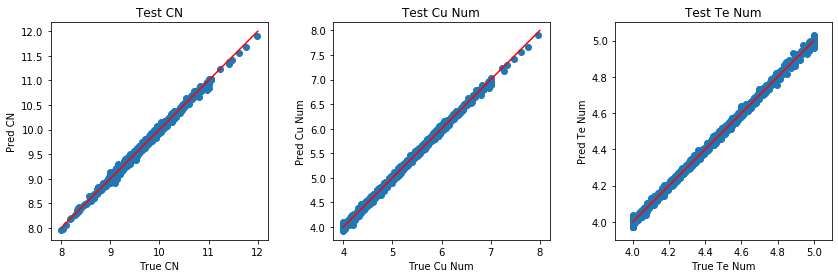

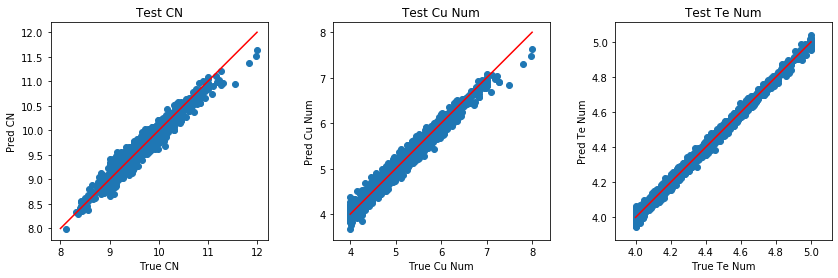

In [6]:
results_df_2 = average_scores_2(iterations, df, Noise_STD)

# Train with both the first and second derivative:

           0
0   0.007542
1   0.000221
2   0.000247
3   0.000288
4   0.000238
5   0.000246
6   0.000244
7   0.000263
8   0.000320
9   0.000250
10  0.000301
11  0.000301
12  0.000297
13  0.000279
14  0.000260
15  0.000238
16  0.000242
17  0.000257
18  0.000294
19  0.000375
20  0.000308
21  0.000275
22  0.000513
23  0.000416
24  0.000307
25  0.000338
26  0.000319
27  0.000461
28  0.000310
29  0.000329
30  0.000313
31  0.000332
32  0.000302
33  0.000305
34  0.000368
35  0.000461
36  0.000290
37  0.000308
38  0.000344
39  0.000274
40  0.000310
41  0.000327
42  0.000322
43  0.000293
44  0.000360
45  0.000304
46  0.000313
47  0.000332
48  0.000332
49  0.000308
50  0.000275
51  0.000339
52  0.000324
53  0.000324
54  0.000352
55  0.000282
56  0.000395
57  0.000329
58  0.000319
59  0.000315
60  0.000315
61  0.000367
62  0.000398
63  0.000492
64  0.000399
65  0.000474
66  0.000319
67  0.000300
68  0.000323
69  0.000331
70  0.000350
71  0.000437
72  0.000321
73  0.000319
74  0.000466
75  0.000326

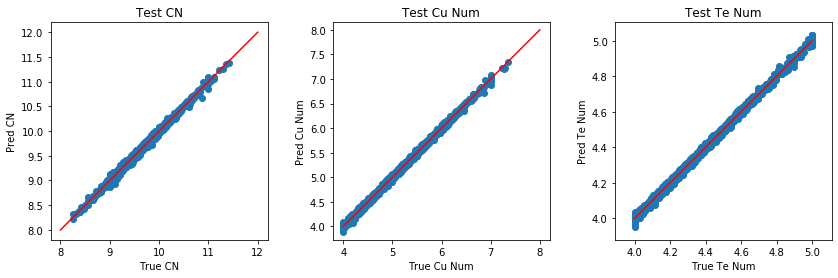

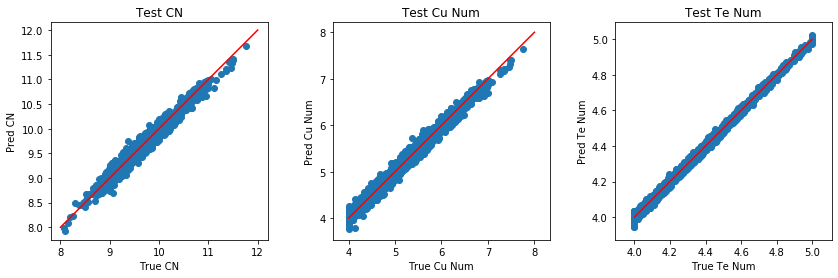

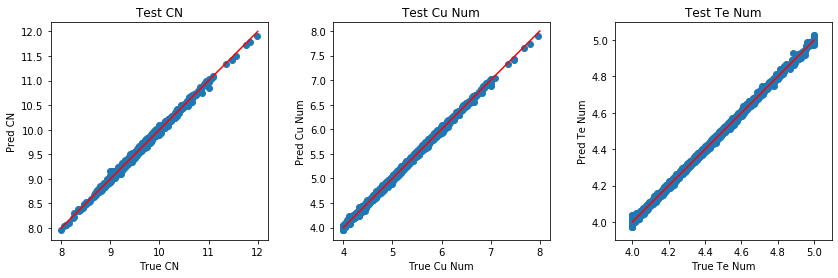

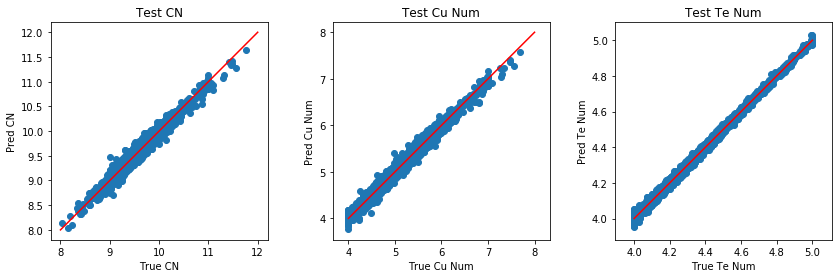

In [7]:
results_df_1_2 = average_scores_1_2(iterations, df, Noise_STD)

# Plot the error for predicting coordination number:

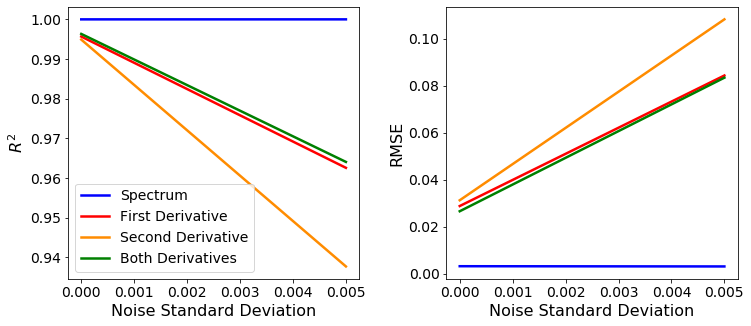

In [16]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(Noise_STD, results_df_spectra['r2_CN'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(Noise_STD, results_df_1['r2_CN'], c='red', lw=2.5, label='First Derivative')
ax1.plot(Noise_STD, results_df_2['r2_CN'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(Noise_STD, results_df_1_2['r2_CN'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(Noise_STD, results_df_spectra['rmse_CN'], c='blue', lw=2.5)
ax2.plot(Noise_STD, results_df_1['rmse_CN'], c='red', lw=2.5)
ax2.plot(Noise_STD, results_df_2['rmse_CN'], c='darkorange', lw=2.5)
ax2.plot(Noise_STD, results_df_1_2['rmse_CN'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Cu:

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(Noise_STD, results_df_spectra['r2_Cu'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(Noise_STD, results_df_1['r2_Cu'], c='red', lw=2.5, label='First Derivative')
ax1.plot(Noise_STD, results_df_2['r2_Cu'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(Noise_STD, results_df_1_2['r2_Cu'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(Noise_STD, results_df_spectra['rmse_Cu'], c='blue', lw=2.5)
ax2.plot(Noise_STD, results_df_1['rmse_Cu'], c='red', lw=2.5)
ax2.plot(Noise_STD, results_df_2['rmse_Cu'], c='darkorange', lw=2.5)
ax2.plot(Noise_STD, results_df_1_2['rmse_Cu'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Te:

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(Noise_STD, results_df_spectra['r2_Te'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(Noise_STD, results_df_1['r2_Te'], c='red', lw=2.5, label='First Derivative')
ax1.plot(Noise_STD, results_df_2['r2_Te'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(Noise_STD, results_df_1_2['r2_Te'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(Noise_STD, results_df_spectra['rmse_Te'], c='blue', lw=2.5)
ax2.plot(Noise_STD, results_df_1['rmse_Te'], c='red', lw=2.5)
ax2.plot(Noise_STD, results_df_2['rmse_Te'], c='darkorange', lw=2.5)
ax2.plot(Noise_STD, results_df_1_2['rmse_Te'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()